# Домашнее задание №2: линейная регрессия (10 баллов).

Некоторые задания будут по вариантам (всего 4 варианта). Чтобы выяснить свой вариант, посчитайте количество букв в своей фамилии, возьмете остаток от деления на 4 и прибавьте 1.

Антон Куценко $\rightarrow$ Вариант 4

In [4]:
import numpy as np
import matplotlib.pyplot as plt


## Многомерная линейная регрессия из sklearn

Применим многомерную регрессию из sklearn для стандартного датасета

In [5]:
from sklearn.datasets import make_regression
X, y = make_regression(n_samples = 10000, random_state=42)
print(X.shape, y.shape)

(10000, 100) (10000,)


У нас 10000 объектов и 100 признаков. Для начала решим задачу аналитически "из коробки".

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

regr = LinearRegression().fit(X, y)
osh1 = mean_squared_error(y, regr.predict(X))
print(mean_squared_error(y, regr.predict(X)))

2.587185251360931e-25


Теперь попробуем обучить линейную регрессию методом градиентного спуска "из коробки"

In [7]:
from sklearn.linear_model import SGDRegressor
reg = SGDRegressor(alpha=0.00000001).fit(X, y)
osh2 = mean_squared_error(y, reg.predict(X))
print(mean_squared_error(y, reg.predict(X)))
reg.coef_

3.965356354236384e-12


array([ 3.75597023e-08,  6.37672897e-08, -5.59948943e-09, -3.71940829e-08,
        2.46961389e-08,  5.56172488e-09, -2.37290157e-08, -4.35955159e-08,
        5.68645675e-08, -5.43009511e-08, -3.80308880e-08,  3.26829624e+01,
       -3.46018473e-08,  2.45759783e-08,  4.62802021e-08,  1.33913762e-08,
       -5.93085182e-08, -1.12283768e-08,  3.55644170e-08, -4.54512235e-09,
        6.67389281e-08,  2.40776950e-09,  2.45548500e-08,  8.26861720e+01,
        2.80816212e-09, -6.96115103e-08, -3.40415543e-09, -4.63311618e-08,
       -1.02613836e-08, -3.51511937e-08, -8.36638661e-09, -7.38338135e-08,
       -4.64945056e-08, -8.30548221e-08, -3.01523744e-08, -8.37011520e-08,
       -4.27278656e-08, -3.81510428e-09,  4.45438322e-08,  1.91317508e-08,
        2.12696059e-08,  3.21576448e-08, -2.72703418e-08,  3.00707399e-08,
        1.22432338e-08,  1.72568045e-08,  5.60394311e+01,  6.32578883e+01,
        1.69423525e-08, -5.28528778e-08, -1.28248535e-08,  1.75466249e-08,
        9.01726066e+01, -

##Задание 1 (1 балл)
 Объясните, чем вызвана разница в значениях двух полученных значений метрики?

Причиной расхождения в значениях MSE стало внутреннее устройство алгоритма, стохастический градиентный спуск имеет параметр шага градиента, который может повлиять на сходимость возле минимума. В то же самое время линейная регрессия из sklearn использует аналитическое решение с обращением матриц. Если количество объектов в наших данных было бы в разы больше( например, 1млн объектов и 100 признаков), то разница во времени обучения была бы уже значительной, при этом качество, конечно, лучше в случае аналитического решения.

##Задание 2 (1 балл)
Подберите гиперпараметры в методе градиентного спуска так, чтобы значение MSE было близко к значению MSE, полученному при обучении LinearRegression.

In [8]:
a = np.linspace(0.00000001, 0.1**25, num = 100) # массив вариантов learning rate
error = osh2 # первоначальная MSE при learning rate = 0.00000001
razn = osh2 - osh1 # первоначальная разница MSE 
for i in a:
  reg = SGDRegressor(alpha=i).fit(X, y)
  k = mean_squared_error(y, reg.predict(X))
  if k  < error:
    error, alp = k, i
razn  = error - osh1  
print("Минимальная MSE при использовании SGD :{}".format(error))
print("Подходящий learning rate: {}".format(alp))
print("Разница MSE LinearRegression и SGD : {}".format(razn))

Минимальная MSE при использовании SGD :9.15459145555654e-25
Подходящий learning rate: 1.0000000000000014e-25
Разница MSE LinearRegression и SGD : 6.56740620419561e-25


## Ваша многомерная линейная регрессия

##Задание 3 (5 баллов)
Напишите собственную многомерную линейную регрессию, оптимизирующую MSE методом *градиентного спуска*. Для этого используйте шаблонный класс. 

Критерий останова: либо норма разности весов на текущей и предыдущей итерациях меньше определенного значения (первый и третий варианты), либо модуль разности функционалов качества (MSE) на текущей и предыдущей итерациях меньше определенного значения (второй и четвертый варианты). Также предлагается завершать обучение в любом случае, если было произведено слишком много итераций.

In [11]:
class LinearRegression(object):
    def __init__(self, alpha=0.485, l_ratio=0.000001, tol=0.1**5, max_iter=1000):
        '''
        Для начала необходимо инициализировать параметры
        alpha - это learning rate или шаг обучения
        l_ratio - параметр регуляризации
        tol - значение для критерия останова
        max_iter - максимальное количество итераций обучения
        '''
        self.max_iter = max_iter
        self.tol= tol
        self.l_ratio = l_ratio
        self.alpha = alpha
             
    def fit(self, X, y):
        '''
        Метод для обучения линейной регрессии
        X - матрица признаков
        y - вектор правильных ответов
        '''
        X = np.column_stack([np.array(X), [1]* X.shape[0]]) #добавим сразу признак, заданный единицами, чтоб не считать два градиента
        y = np.array(y)
        w = np.array([0]* (X.shape[1]))
        n = len(y)
        for i in range(self.max_iter):
          y_current = np.matmul(X,w) 
          cost1 = (1/n) * sum((y - y_current)**2) 
          w_gradient = (2/n) * (-np.matmul(np.transpose(X), y) + np.matmul(np.matmul(np.transpose(X), X), w)) 
          w = w - self.alpha * w_gradient
          y_current = np.matmul(X,w)
          cost2 = (1/n) * sum((y - y_current)**2) 
          if cost1 - cost2 <= self.tol:
            break
        self.w = w

        return w, cost2 
    def predict(self, X):
        '''
        Метод для предсказаний линейной регрессии
        X - матрица признаков
        '''
        X = np.column_stack([np.array(X), [1]* X.shape[0]])
        y_pred = np.matmul(X, self.w)
        return y_pred

In [12]:
X, y = make_regression(n_samples = 10000, random_state=42)
my_reg = LinearRegression(tol=0.1**20) #изменяя значение для критерия останова, мы улучшаем качество, но тереям время
my_reg.fit(X, y)
print('MSE:',mean_squared_error(y, my_reg.predict(X)))
assert mean_squared_error(y, my_reg.predict(X)) < 1e-3
print('You are amazing! Great work!')

MSE: 2.4082186853954137e-22
You are amazing! Great work!


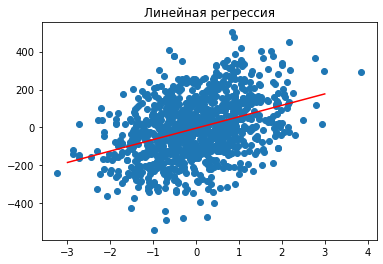

In [13]:
#Проверка работоспособности алгоритма на двухмерном случае
#Подобрал специально random_state с более менее линейной связью данных
from sklearn.datasets import make_regression
X, y = make_regression(n_samples = 1000, random_state=42)
X = X[:,:1]
my_reg = LinearRegression(tol=0.1**20)
x1 = np.linspace(-3,3)
y1 = x1 * my_reg.fit(X, y)[0][0] + my_reg.fit(X, y)[0][1]
plt.plot(x1,y1, color='red')
plt.scatter(X,y)
plt.title('Линейная регрессия')
plt.show()

##Задание 4 (2 балла)
Добавьте l1 (первый и четвертый варианты) или l2 (второй и третий варианты) регуляризацию. 

In [49]:
class LinearRegression_1(object):
    def __init__(self, alpha=0.485, l_ratio=0.1**10, tol=0.1**20, max_iter=10000):
        '''
        Для начала необходимо инициализировать параметры
        alpha - это learning rate или шаг обучения
        l_ratio - параметр регуляризации
        tol - значение для критерия останова
        max_iter - максимальное количество итераций обучения
        '''
        self.max_iter = max_iter
        self.tol= tol
        self.l_ratio = l_ratio
        self.alpha = alpha
             
    def fit(self, X, y):
        '''
        Метод для обучения линейной регрессии
        X - матрица признаков
        y - вектор правильных ответов
        '''
        X = np.column_stack([np.array(X), [1]* X.shape[0]])
        y = np.array(y)
        w = np.array([0]* (X.shape[1]))
        n = len(y)
        lol = []
        for i in range(self.max_iter):
          y_current = np.matmul(X,w) 
          cost1 = (1/n) * sum((y - y_current)**2) + sum(np.absolute(w))
          w_gradient = (2 / n) * (-np.matmul(np.transpose(X), y) + np.matmul(np.matmul(np.transpose(X), X), w)) + self.l_ratio * np.sign(w)
          w = w - self.alpha * w_gradient
          y_current = np.matmul(X,w)
          cost2 = (1/n) * sum((y - y_current)**2) + sum(np.absolute(w))
          if cost1 - cost2 <= self.tol:
            break
        self.w = w
        print(w)

        return w, cost2 
    def predict(self, X):
        '''
        Метод для предсказаний линейной регрессии
        X - матрица признаков
        '''
        X = np.column_stack([np.array(X), [1]* X.shape[0]])
        y_pred = np.matmul(X, self.w)
        return y_pred

In [50]:
X, y = make_regression(n_samples = 10000, random_state=42)
my_reg = LinearRegression_1()
my_reg.fit(X, y)
assert mean_squared_error(y, my_reg.predict(X)) < 1e-3
print('You are amazing! Great work!')
print('MSE:',mean_squared_error(y, my_reg.predict(X)))

[-5.09289583e-11  5.01486764e-11  4.53474549e-11 -4.94660429e-11
 -5.83686725e-11  4.95452741e-11 -4.77000113e-11 -4.95655155e-11
  5.24858373e-11 -4.86504443e-11  4.35955530e-11  3.26829628e+01
  5.43471615e-11 -5.36764855e-11  4.96738180e-11  4.69764718e-11
  4.21687523e-11 -5.10498563e-11 -5.58764776e-11 -4.81311616e-11
  5.28710360e-11  5.51490070e-11 -4.96503567e-11  8.26861728e+01
  4.41575681e-11 -5.10200731e-11  5.33525149e-11  4.83470297e-11
 -5.08456600e-11 -5.06256200e-11  4.18270050e-11  4.72339715e-11
  5.39166621e-11  4.44011967e-11  4.17856497e-11 -5.53240902e-11
 -4.88000708e-11  4.71130635e-11  4.57868759e-11 -4.32849540e-11
  4.23883390e-11 -4.90687934e-11  3.96419499e-11  4.86094827e-11
  4.77749965e-11  4.13175916e-11  5.60394317e+01  6.32578889e+01
  4.55658284e-11  4.66184216e-11  5.74006734e-11  5.34669353e-11
  9.01726076e+01 -4.83168283e-11  5.50414324e-11  4.86272106e-11
  4.66292117e-11  2.05715140e+01  7.15561938e+01 -4.61325315e-11
 -4.37844351e-11  4.70673

##Задание 5 (1 балл)
 Обучите линейную регрессию из коробки с l1-регуляризацией (from sklearn.linear_model import Lasso, первый и четвертый варианты) или с l2-регуляризацией (from sklearn.linear_model import Ridge, второй и третий варианты) с значением параметра регуляризации 0.1. Обучите вашу линейную регрессию с тем же значением параметра регуляризации и сравните результаты. Сделайте выводы.

In [51]:
from sklearn.linear_model import Lasso

In [52]:
regres = Lasso(0.1)
regres.fit(X,y)
print('MSE линейной регрессии из коробки с l1-регуляризацией:{}'.format(mean_squared_error(y,regres.predict(X))))
regres.coef_

MSE линейной регрессии из коробки с l1-регуляризацией:0.10130120734785844


array([-0.        ,  0.        , -0.        ,  0.        , -0.        ,
        0.        , -0.        , -0.        ,  0.        ,  0.        ,
       -0.        , 32.57713139,  0.        , -0.        ,  0.        ,
       -0.        , -0.        , -0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.        , 82.58541362,  0.        ,
       -0.        ,  0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        ,  0.        , -0.        ,  0.        ,
       -0.        , -0.        ,  0.        ,  0.        ,  0.        ,
       -0.        ,  0.        , -0.        , -0.        ,  0.        ,
       -0.        , 55.93631958, 63.15834586, -0.        , -0.        ,
        0.        ,  0.        , 90.07374492, -0.        ,  0.        ,
       -0.        , -0.        , 20.46611002, 71.45590813,  0.        ,
       -0.        ,  0.        , -0.        ,  0.        ,  0.        ,
       -0.        ,  0.        , 21.04876285, -0.        ,  0.  

In [55]:
regres_1 = LinearRegression_1(l_ratio=0.1)
regres_1.fit(X,y)
print('MSE моей линейной регрессии с l1-регуляризацией:{}'.format(mean_squared_error(y,regres_1.predict(X))))

[ 6.15234076e-02  4.41076068e-02  5.04206829e-02 -4.86130490e-02
  4.47197910e-02  5.15542363e-02  5.68793653e-02 -6.00101357e-02
 -4.93116926e-02  5.13594553e-02  5.23071222e-02  3.26333591e+01
  6.08867155e-02  4.71870947e-02  5.10841327e-02  6.09516675e-02
  4.74930272e-02  5.43766833e-02 -4.85950160e-02  4.65012984e-02
 -4.09596431e-02  5.09527091e-02  5.27958015e-02  8.26169736e+01
  5.50161879e-02  4.65593001e-02 -4.88220849e-02  4.68277217e-02
 -4.44100760e-02  4.63765083e-02 -5.46863435e-02  5.09466307e-02
 -4.15849132e-02  4.68703469e-02  5.66730063e-02  5.36803363e-02
 -4.73709887e-02 -4.59916474e-02 -5.65305753e-02  5.77505188e-02
  5.20369841e-02  6.05322165e-02  4.96070071e-02  4.44578747e-02
 -6.03281310e-02 -5.29355773e-02  5.59789506e+01  6.31958350e+01
  5.07723737e-02  4.91373744e-02 -4.56930065e-02 -4.61374328e-02
  9.01096021e+01  4.05661683e-02 -3.56892376e-02  4.67426171e-02
  5.11844072e-02  2.05148328e+01  7.14879609e+01 -5.21048464e-02
  4.71802816e-02 -4.82161

Встроенная регрессия с регуляризацией имеет меньшую MSE и большинство параметров вектора w обнуляются, в моей модели те же параметры стрмятся к обнулению, однако не доходят до нуля, приобретая просто очень маленькие значения. Скорее всего, такие различия связаны со внутренним устройством алгоритмов, в моей модели используется классический градиентный спуск, а в Lasso метод покоординатного спуска.